<a href="https://colab.research.google.com/github/pedro-de-bastos/CS146/blob/master/CS146_Assignment_Posterior_Predictive_Checks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CS146 Assignment: Posterior Predictive Checks
By: Pedro Martins de Bastos


## Investigating the Posterior

The first step in the process of creating a predictive posterior distribution over a test statistic is to have your posterior. Below, I simply took the posterior that we were given in class and plotted it to visualize how the distribtion of $\theta$, the probability of improvement/recovery of each patient, is modeled.

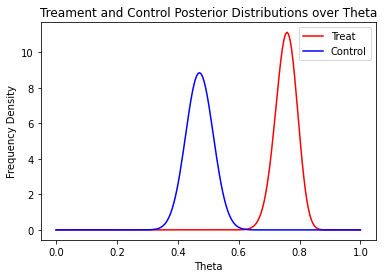

In [1]:
import scipy.stats as sts
import numpy as np
import matplotlib.pyplot as plt

x = np.linspace(0, 1, num=200)
treat_posterior = sts.beta(108, 35)
cont_posterior = sts.beta(58, 65)
plt.plot(x, treat_posterior.pdf(x), color = 'r', label='Treat')
plt.plot(x, cont_posterior.pdf(x), color = 'b', label='Control')
plt.xlabel("Theta")
plt.ylabel("Frequency Density")
plt.title("Treament and Control Posterior Distributions over Theta")
plt.legend()

## Determining What to Sample and How to Sample It

For this assignment, we are focusing on the $\theta$ distribution for the control group. The first step in creating a predictive posterior, therefore, was to sample a value of $\theta$ from our posterior distribution:

$\theta \sim \beta(58, 65)$


Having our sample from the posterior, we can now use that sample in our likelihood function, a binomial as specified by our model. Note that the output of the binomial is the number of successful improvements, $s_i$, given a number of patients $n_i$. The binomial distribution takes in two parameters, $\theta$ and $n_i$, but only one comes from our posterior distribution as it stands. Thus, to be able to show a histogram of the replicated number of successes (or of a test statistic calculated over these values) we need to (a) decide how many patients per simulation and (b) normalize the values so that they become comparable (we could ignore the fact that different values are being sampled from binomials with different numbers of patients, but since the distribution of patients per trial may not be symmetrical, we could be biasing our results). 

To decide on the values of $n_i$, we can simply use the values in the data (i.e. the number of patients for each trial, as specificed by the studies) or we can parametrize $n_i$ and sample it from a new distribution. I thought that the latter would allow for more flexibility in the model, at the expense of a little bit more complexity and uncertainty.

I decided to model the number of patients in a given trial as a normal distribution, centered at 20 patients with a standard deviation of 10 patients. Furthermore, I truncated the distribution to make sure that we don't have trials with less than 5 patients or more than 50 patients. That is:

$n_i \sim N(\mu = 20, \sigma = 10), n_i \in [5, 50].$

Finally, we use the value of $\theta$ we sampled, as well as the values of $n_i$, to simulate new data. 

$s_i \sim Binom(n_i, \theta)$

$\hat{\theta} = \frac{s_i}{n_i}$.

Note that the normalized version of the number of successes, $\hat{\theta}$ is in fact analogous to $\theta$ itself, since it is the simulated fraction of successful recoveries.

I then transformed these simulated samples by applying the test statistic of choice, which I discuss below.

In [15]:
#Real data:
data = [9/15, 11/18, 4/10, 21/39, 12/29, 0/10] #These are the fractions we had
#from the real studies representing the successful recoveries over number of
#patients

def posterior_samples(test_stat, posterior, patients_mean):
  sample_list = []
  for i in range(10000):
    #sampling a theta from our posterior:
    posterior_sample = posterior.rvs() 

    #sampling a number of patients for a given trial:
    patients = sts.norm.rvs(loc=patients_mean, scale=10, size=6)
    patients = patients[np.logical_and(patients>5, patients <50)].astype(int)
    
    #simulating a new study based on the number of patients and the sampled 
    #theta:
    samples = sts.binom.rvs(patients, posterior_sample)/patients
    sample_list.append(test_stat(samples))
  return sample_list

## Discussing Results and Test Statistics

I experimented with a few different test statistics, as well as with how changing hyperparameters like the mean number of patients per trial change the test statistic distribution. I experimented with the range, mean, standard deviation and finally the minimum value, and I ultimately settled on the 'min' function being the most important test after visualizing the histogram of the original data and the histogram of the mean value of the simulated data, shown below:

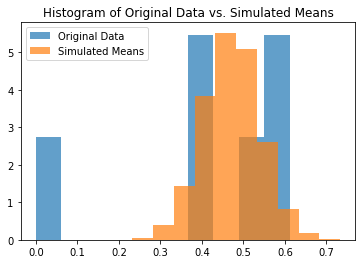

In [20]:
plt.hist(data, density= True, alpha = 0.7, label="Original Data")
plt.hist(posterior_samples(np.mean, cont_posterior, 20), density=True, alpha = 0.7, label = "Simulated Means")
plt.title("Histogram of Original Data vs. Simulated Means")
plt.legend()

The above result shows us that the simlated means are consistently around 0.45, but that the original values for $\theta$ could be as small as 0. Because of the existence of this outlier, I decided to check whether the model can produce minimum results that are in line with this outlier value (i.e., how often does the model produce a minimum $\theta$ value of 0?)

Your p-values is: 0.9899


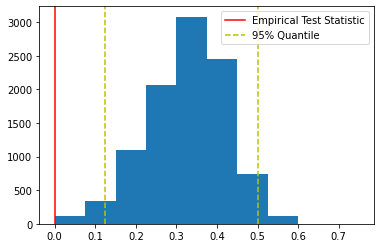

In [21]:
#Sampling function parameters
test_stat = np.min #the min function is very appropriate because we have a very 
#anomolous result for the data: we have one trial with 10 patients, out of 
#which 0 recovered. A good model would have to be able to explain that
patients_mean = 20 #this was a prior I set based on knowledge of how many people
#participate in such studies
posterior = cont_posterior

samples = posterior_samples(test_stat, posterior, patients_mean)
quantile = np.quantile(samples, (0.025, 0.975))


plt.hist(samples)
plt.axvline(x=test_stat(data), color='r', label='Empirical Test Statistic')
plt.axvline(x=quantile[0], color = 'y', ls='--', label='95% Quantile')
plt.axvline(x=quantile[1], color = 'y', ls='--')

plt.legend()
print(f"Your p-values is: {(sum(test_stat(data)<samples))/len(samples)}")

The answer to my question, as depicted by the histogram above, is that only in 0.93% of instances do we expect a test statistic with value 0, given our model. We can see from the figure above that the red line, representing the measured test statistic, is way below the 95% confidence interval boundary. This means that our non-hierarchical model is not doing well in explaining real life data, and that therefore we might have to turn to a hierarchical model, or a refinement of the existing hierarchical model, to make better predictions.